In [8]:
# Cell 1: Imports and global configuration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

sns.set_theme(style="whitegrid")               # Use a clean white-grid style
plt.rcParams["figure.figsize"] = (12, 6)       # Default figure size


In [9]:
# Cell 2: Load and preprocess the data
file_path = "../../raw_data/clean_data/clean_data_dd.csv"

try:
    df = pd.read_csv(file_path)
except FileNotFoundError as e:
    raise FileNotFoundError(f"Error loading data: {e}. Please check the file path.")

# Ensure Year is integer and drop bad rows
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

# Aggregate counts per year
year_counts = df.groupby("Year").size().reset_index(name="Count")


# Descriptive Analysis

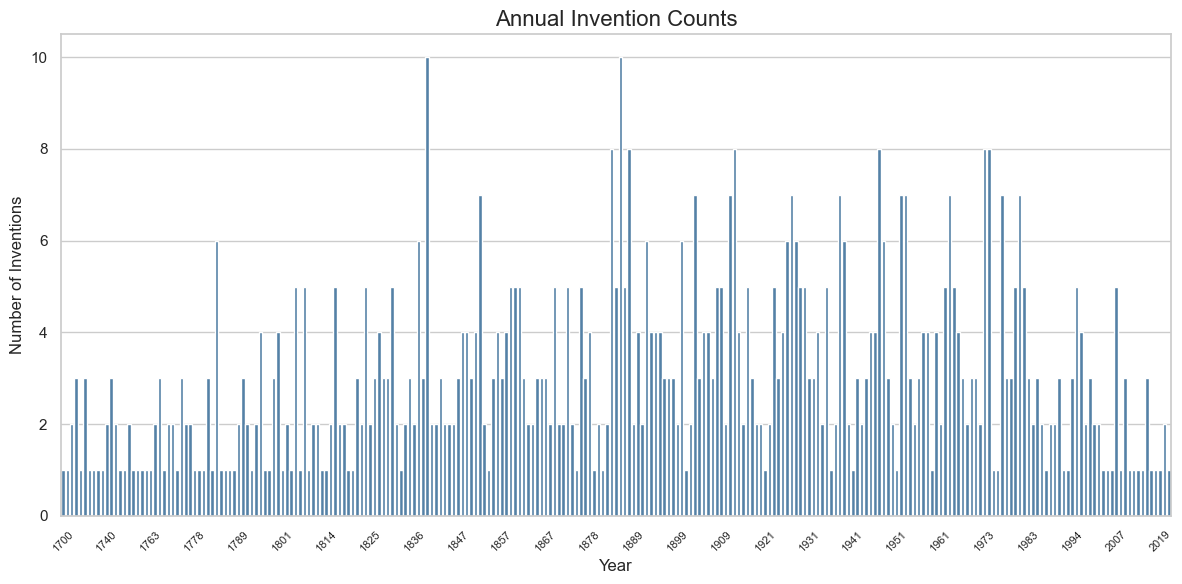

In [10]:
# Cell 3: Bar chart of annual invention counts
fig, ax = plt.subplots()
sns.barplot(x="Year", y="Count", data=year_counts, color="steelblue", ax=ax)

ax.set_title("Annual Invention Counts", fontsize=16)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Inventions", fontsize=12)

# Thin out the x-ticks: show every 10th year only
ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
plt.xticks(rotation=45, fontsize=8)

plt.tight_layout()
plt.show()


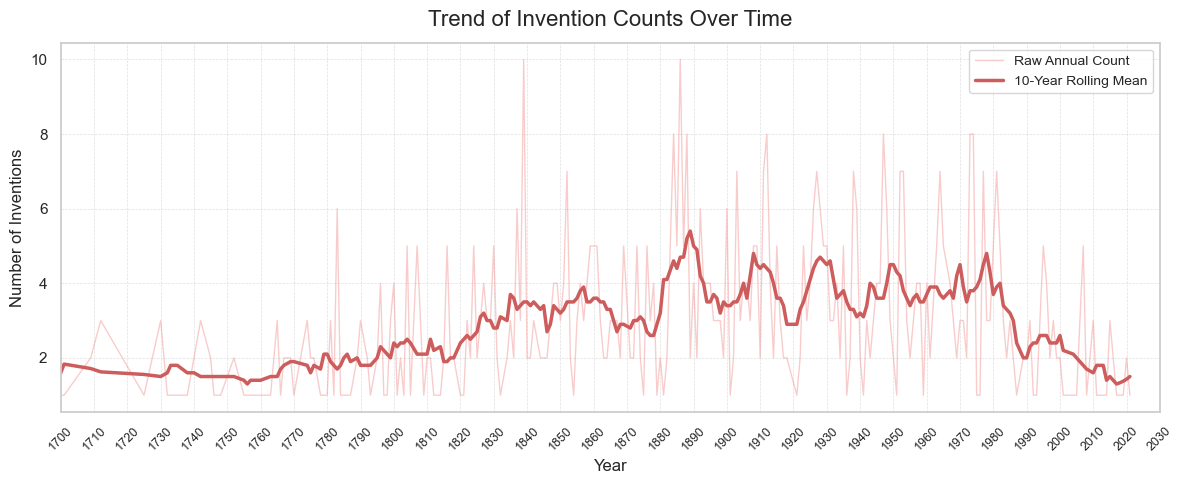

In [86]:
# Cell 4 Smooth trend line with rolling average

import matplotlib.ticker as mticker

# Compute a 9-year centered rolling mean
year_counts['Smoothed'] = (
    year_counts['Count']
    .rolling(window=10, center=True, min_periods=1)
    .mean()
)

fig, ax = plt.subplots(figsize=(12, 5))

# Plot raw annual counts (fainter)
sns.lineplot(
    x="Year", y="Count",
    data=year_counts,
    color="lightcoral",
    alpha=0.4,
    linewidth=1,
    ax=ax,
    label="Raw Annual Count"
)

# Plot smoothed curve (bold)
sns.lineplot(
    x="Year", y="Smoothed",
    data=year_counts,
    color="indianred",
    linewidth=2.5,
    ax=ax,
    label="10-Year Rolling Mean"
)

# Formatting
ax.set_title("Trend of Invention Counts Over Time", fontsize=16, pad=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Inventions", fontsize=12)

# Fix x-axis range and ticks every 10 years
ax.set_xlim(1700, 2030)
ax.xaxis.set_major_locator(mticker.FixedLocator(list(range(1700, 2031, 10))))
ax.xaxis.set_minor_locator(mticker.FixedLocator(list(range(1700, 2031, 5))))
ax.tick_params(axis='x', labelrotation=45, labelsize=9)

ax.legend(title=None, fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()


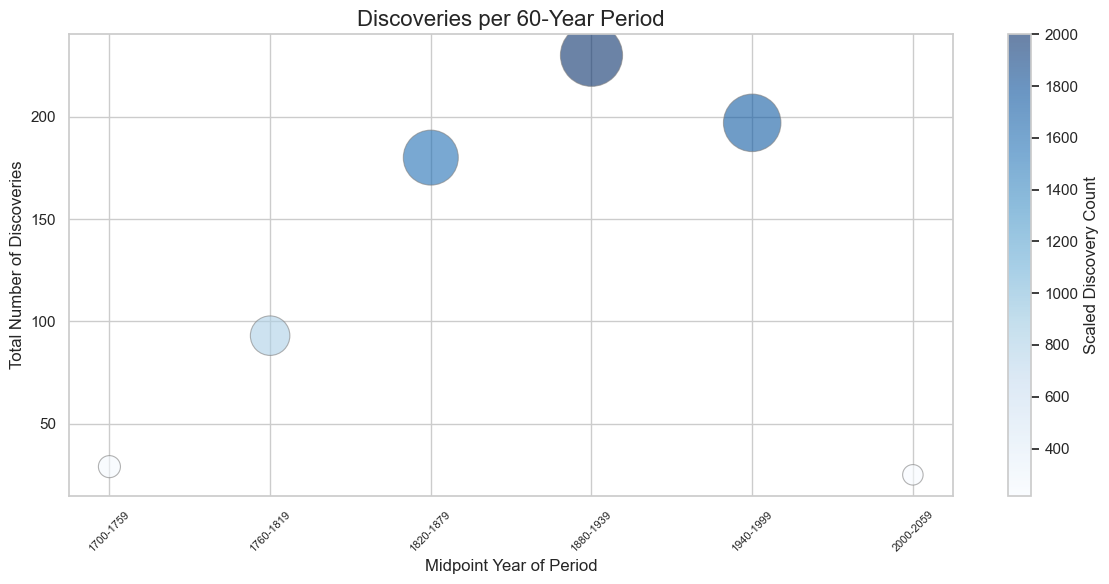

In [12]:
# Cell 5: Bubble chart of discoveries aggregated every 60 years
import numpy as np

# Define 60-year bins from 1700 to 2030
bins = np.arange(1700, 2030, 60)
# Extend the last bin's right edge
bin_edges = np.append(bins, bins[-1] + 60)
# Label each bin as "start–end"
labels = [f"{start}-{start+59}" for start in bins]

# Assign each year to a 60-year period
temp = year_counts.copy()
temp['Period'] = pd.cut(temp['Year'], bins=bin_edges, labels=labels, right=True)

# Sum counts within each period
period_counts = temp.groupby('Period')['Count'].sum().reset_index()

# Compute x-coordinate as the midpoint of each period
period_counts['MidYear'] = bins + 30

# Scale bubble sizes (max size ~2000)
max_count = period_counts['Count'].max()
sizes = (period_counts['Count'] / max_count) * 2000

# Plot the bubble chart
fig, ax = plt.subplots()
scatter = ax.scatter(
    period_counts['MidYear'],
    period_counts['Count'],
    s=sizes,
    alpha=0.6,
    c=sizes,                    # color by size for a gradient effect
    cmap='Blues',
    edgecolors='grey',
    linewidth=0.8
)

# Titles and labels
ax.set_title("Discoveries per 60-Year Period", fontsize=16)
ax.set_xlabel("Midpoint Year of Period", fontsize=12)
ax.set_ylabel("Total Number of Discoveries", fontsize=12)

# Set x-ticks at the start of each period
ax.set_xticks(bins + 30)
ax.set_xticklabels(labels, rotation=45, fontsize=8)

# Add a colorbar for bubble size reference
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label("Scaled Discovery Count", fontsize=12)

plt.tight_layout()
plt.show()


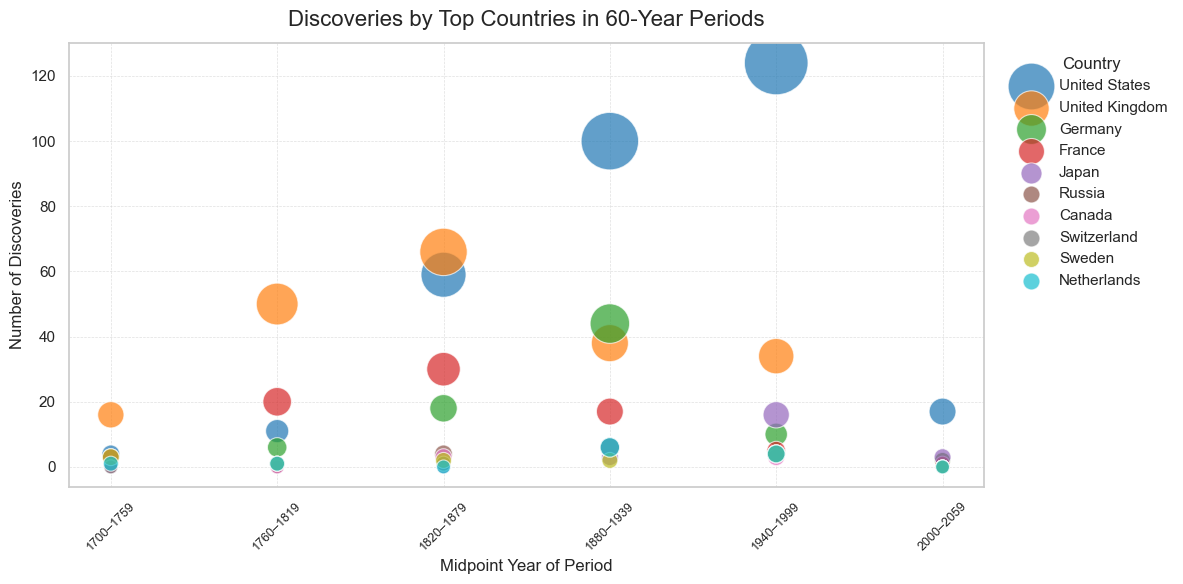

In [ ]:
# Cell 6: Bubble chart of discoveries by top countries in 60-year periods

import numpy as np

# 1. Split multi-country entries and explode into one row per country
df_expanded = df.copy()
df_expanded['Country'] = df_expanded['Country'].str.split(';')
df_expanded = df_expanded.explode('Country')
df_expanded['Country'] = df_expanded['Country'].str.strip()

# 2. Define 60-year bins and labels
bins = np.arange(1700, 2031, 60)
bin_edges = np.append(bins, bins[-1] + 60)
labels = [f"{start}–{start+59}" for start in bins]
df_expanded['Period'] = pd.cut(df_expanded['Year'], bins=bin_edges, labels=labels, right=False)

# 3. Compute total counts per country over all periods to pick top N
total_by_country = (
    df_expanded
    .groupby('Country')
    .size()
    .sort_values(ascending=False)
)
top_countries = total_by_country.head(10).index.tolist()  # top 8 countries

# 4. Filter to top countries, count per period
period_country = (
    df_expanded[df_expanded['Country'].isin(top_countries)]
    .groupby(['Period', 'Country'])
    .size()
    .reset_index(name='Count')
)

# 5. Compute midpoint year for plotting
period_country['MidYear'] = period_country['Period'].apply(
    lambda lab: int(lab.split('–')[0]) + 30
)

# 6. Scale bubble sizes: area proportional to count
max_count = period_country['Count'].max()
period_country['Size'] = (period_country['Count'] / max_count) * 2000 + 100

# 7. Plot
fig, ax = plt.subplots(figsize=(12, 6))
palette = sns.color_palette("tab10", len(top_countries))
color_map = dict(zip(top_countries, palette))

for country in top_countries:
    subset = period_country[period_country['Country'] == country]
    ax.scatter(
        subset['MidYear'],
        subset['Count'],
        s=subset['Size'],
        label=country,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.8,
        color=color_map[country]
    )

# 8. Aesthetics
ax.set_title("Discoveries by Top Countries in 60-Year Periods", fontsize=16, pad=12)
ax.set_xlabel("Midpoint Year of Period", fontsize=12)
ax.set_ylabel("Number of Discoveries", fontsize=12)

ax.set_xticks(bins + 30)
ax.set_xticklabels(labels, rotation=45, fontsize=9)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.legend(title="Country", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()


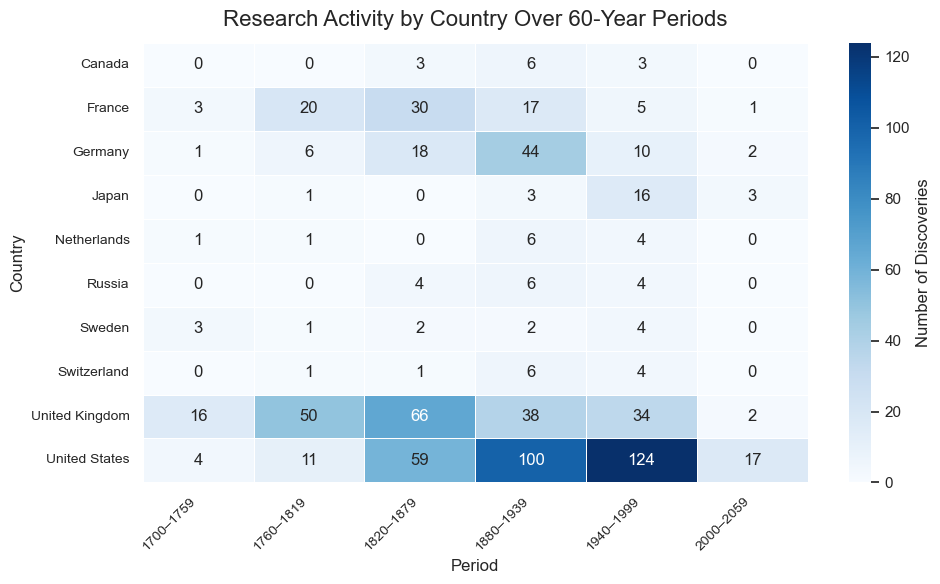

In [16]:
# Cell 7: Heatmap of discovery activity by country over 60-year periods
# Building on the exploded & top-N logic from Cell 5

# 1. Pivot the period-country counts into a matrix
heatmap_data = (
    period_country
    .pivot(index='Country', columns='Period', values='Count')
    .fillna(0)
)

# 2. Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    cmap='Blues',          # blue gradient
    linewidths=0.5,        # lines between cells
    linecolor='white',     # white grid lines
    annot=True,            # show counts
    fmt='g',               # integer format
    cbar_kws={'label': 'Number of Discoveries'}
)

# 3. Aesthetics
plt.title("Research Activity by Country Over 60-Year Periods", fontsize=16, pad=12)
plt.xlabel("Period", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


# EDA

### Loads and smooths the annual invention counts with a 10-year rolling mean, then plots both raw and smoothed series. Major events are drawn as colored vertical dashed lines, with slanted labels at the top.


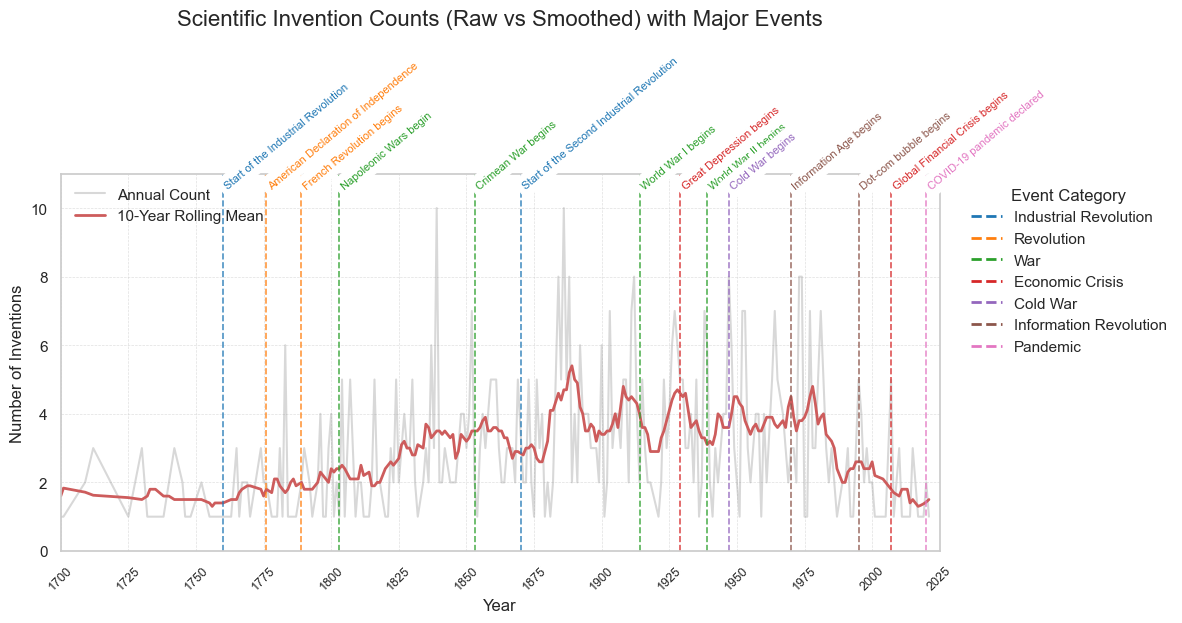

In [58]:
# Cell 9: Time series with rolling average and event annotations

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Load annual invention counts
year_counts = (
    pd.read_csv('../../raw_data/clean_data/clean_data_dd.csv')
      .assign(Year=lambda df: pd.to_numeric(df.Year, errors='coerce'))
      .dropna(subset=['Year'])
      .astype({'Year':'int'})
      .groupby('Year')['Name of Invention'].size()
      .reset_index(name='Count')
)

# Compute 10-year centered rolling mean to smooth noise
year_counts['RollingMean'] = (
    year_counts['Count']
      .rolling(window=10, center=True, min_periods=5)
      .mean()
)

# Load major events
events = pd.read_csv('../../raw_data/clean_data/major_events.csv')

# Prepare a color for each category
categories = events['Category'].unique()
palette = sns.color_palette('tab10', len(categories))
cat_colors = dict(zip(categories, palette))

# Plot raw counts and rolling mean
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(top=0.5) 
ax.plot(
    year_counts['Year'],
    year_counts['Count'],
    color='gray',
    alpha=0.3,
    label='Annual Count'
)
ax.plot(
    year_counts['Year'],
    year_counts['RollingMean'],
    color='indianred',
    linewidth=2,
    label='10-Year Rolling Mean'
)

# Annotate events with vertical lines and slanted labels
y_max = year_counts['Count'].max() * 1.05
for i, row in events.iterrows():
    x = int(row['Year'])
    color = cat_colors[row['Category']]
    ax.axvline(x=x, color=color, linestyle='--', linewidth=1.2, alpha=0.8)
    ax.text(
        x, y_max,
        row['Event Name'],
        rotation=40,
        ha='left',
        va='bottom',
        fontsize=8,
        backgroundcolor='white',
        color=color
    )

# Axis formatting
ax.set_xlim(1700, 2025)
ax.set_ylim(0, year_counts['Count'].max() * 1.1)
ax.xaxis.set_major_locator(mticker.MultipleLocator(25))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(5))
ax.tick_params(axis='x', labelsize=9, rotation=45)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Inventions', fontsize=12)
ax.set_title(
    'Scientific Invention Counts (Raw vs Smoothed) with Major Events',
    fontsize=16,
    pad=12,
    y =1.35

)
# ax.legend(loc='upper left')

# ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
# plt.tight_layout()
# plt.show()

# 2. Legend for raw vs smoothed (upper left, no frame)
raw_handles, raw_labels = ax.get_legend_handles_labels()
legend1 = ax.legend(
    raw_handles, raw_labels,
    loc='upper left', title=None,
    frameon=False
)

# 3. Legend for event categories on the right
event_handles = [
    plt.Line2D([0], [0], linestyle='--', color=cat_colors[cat], lw=2)
    for cat in categories
]
legend2 = ax.legend(
    event_handles, categories,
    title='Event Category',
    bbox_to_anchor=(1.02, 1), loc='upper left',
    frameon=False
)
# re‐attach the first legend
ax.add_artist(legend1)

# Grid & layout
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


### For each event, a comparison of average annual invention counts in the 10 years before vs. the 10 years after the event. It runs Welch’s t-test to assess significance, then visualizes the before/after means in a grouped horizontal bar chart and prints a table of results.

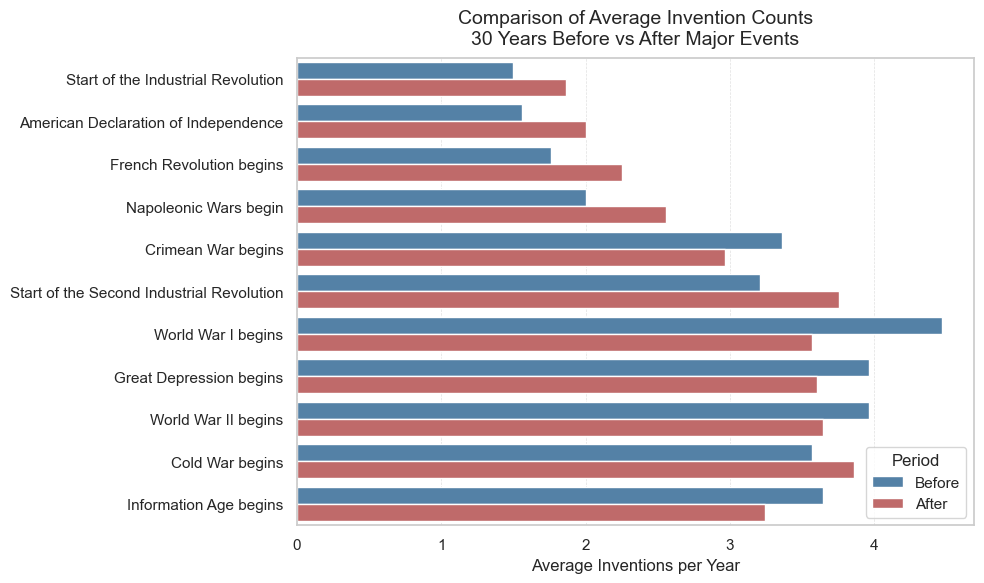

                                        Event                Category  \
0          Start of the Industrial Revolution   Industrial Revolution   
1        American Declaration of Independence              Revolution   
2                    French Revolution begins              Revolution   
3                       Napoleonic Wars begin                     War   
4                          Crimean War begins                     War   
5   Start of the Second Industrial Revolution   Industrial Revolution   
6                          World War I begins                     War   
7                     Great Depression begins         Economic Crisis   
8                         World War II begins                     War   
9                             Cold War begins                Cold War   
10                     Information Age begins  Information Revolution   

   BeforePeriod AfterPeriod  MeanBefore  MeanAfter   p-value  
0     1730–1759   1761–1790    1.500000   1.863636  0.275010

In [59]:
# Cell 10: Before-and-after event comparison (10-year windows + t-test)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Use year_counts and events from Cell 9
# Prepare statistics
window = 30
stats = []
min_year = year_counts['Year'].min()
max_year = year_counts['Year'].max()

for _, row in events.iterrows():
    year = int(row['Year'])
    before_start = year - window
    before_end = year - 1
    after_start = year + 1
    after_end = year + window

    # Skip if window out of bounds
    if before_start < min_year or after_end > max_year:
        continue

    before = year_counts[
        (year_counts['Year'] >= before_start) &
        (year_counts['Year'] <= before_end)
    ]['Count']
    after = year_counts[
        (year_counts['Year'] >= after_start) &
        (year_counts['Year'] <= after_end)
    ]['Count']

    mean_before = before.mean()
    mean_after = after.mean()
    # Welch’s t-test
    t_stat, p_value = ttest_ind(after, before, equal_var=False)

    stats.append({
        'Event': row['Event Name'],
        'Category': row['Category'],
        'BeforePeriod': f"{before_start}–{before_end}",
        'AfterPeriod': f"{after_start}–{after_end}",
        'MeanBefore': mean_before,
        'MeanAfter': mean_after,
        'p-value': p_value
    })

stats_df = pd.DataFrame(stats)

# Melt for plotting
melted = stats_df.melt(
    id_vars=['Event'],
    value_vars=['MeanBefore', 'MeanAfter'],
    var_name='Period',
    value_name='AverageCount'
)
melted['Period'] = melted['Period'].map({
    'MeanBefore': 'Before',
    'MeanAfter': 'After'
})

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=melted,
    x='AverageCount',
    y='Event',
    hue='Period',
    palette=['steelblue', 'indianred'],
    ax=ax
)

ax.set_xlabel('Average Inventions per Year', fontsize=12)
ax.set_ylabel('')
ax.set_title(
    f'Comparison of Average Invention Counts\n{window} Years Before vs After Major Events',
    fontsize=14, pad=10
)
ax.legend(title='Period', loc='lower right')
ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# Display statistical results
print(stats_df[['Event', 'Category', 'BeforePeriod', 'AfterPeriod', 'MeanBefore', 'MeanAfter', 'p-value']])


Using a 30-year before-and-after window smooths out the short-term noise and gives a broader perspective on how major events align with longer trends in invention activity. Across the Industrial Revolutions and political upheavals, average counts rise modestly after each event, reflecting that these periods really do coincide with an upward shift in innovation, even if the change is gradual. For example, the First Industrial Revolution shows an increase from about 1.5 to 1.86 inventions per year, and the Second from about 3.21 to 3.76. These rises are not statistically decisive in a strict t-test sense (all p-values remain above 0.1), but they do track the overall acceleration of technology.

World War I again stands out: even over a three-decade span, average inventions drop from about 4.47 to 3.57, with a p-value nearing significance (≈0.098). That suggests the Great War’s disruption left a lasting dent in scientific output that only slowly recovered. By contrast, World War II, the Cold War, and the Information Age each show only small shifts in their 30-year windows, confirming that those later events blended into already strong growth trends.

Overall, extending the window to 30 years confirms that sweeping industrial and technological revolutions coincide with sustained growth in invention rates, while acute shocks like World War I can cause more than just a short dip. It also shows that some crises or conflicts have gentler effects that get absorbed into the longer cycle. This longer-horizon view helps us understand how large-scale transformations reshape innovation over generations, not just in the immediate decade that follows.

<Figure size 1200x600 with 0 Axes>

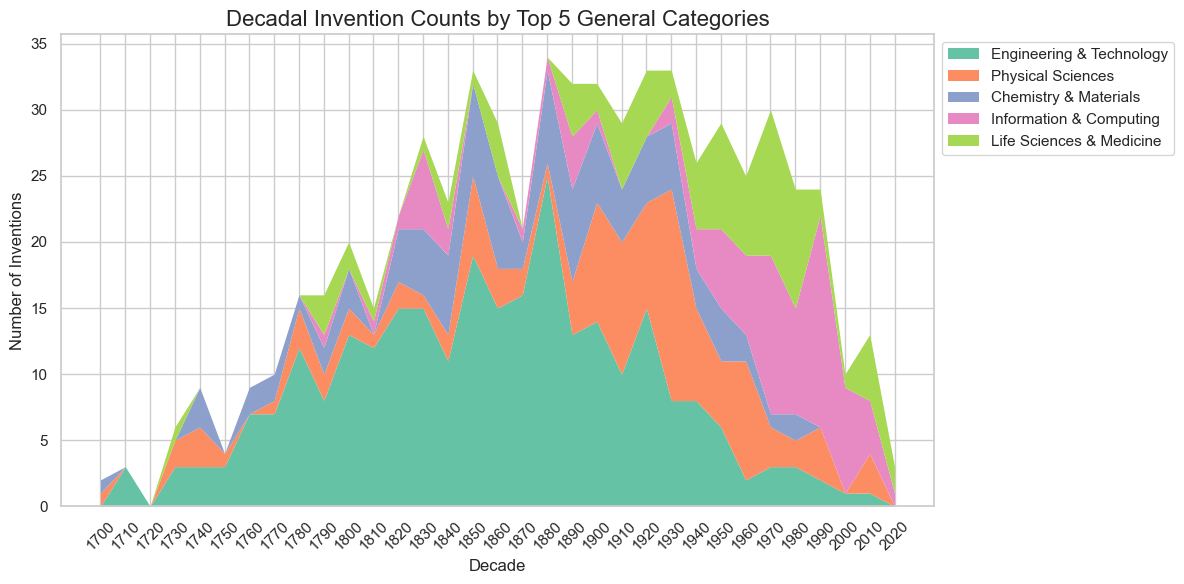

In [ ]:
# Cell 11 (fixed palette usage): Decadal invention counts by top 5 categories

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare
df = pd.read_csv('../../raw_data/clean_data/clean_data_dd.csv')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(int)
df['Decade'] = (df['Year'] // 10) * 10

# Aggregate per decade and category
decade_cat = (
    df.groupby(['Decade', 'General_Category'])
      .size()
      .reset_index(name='Count')
)
pivot_decade = decade_cat.pivot(index='Decade',
                                columns='General_Category',
                                values='Count').fillna(0)

# Pick top 5 categories
top5 = pivot_decade.sum().sort_values(ascending=False).head(5).index
pivot_top5 = pivot_decade[top5]

# Choose a Seaborn palette list
palette = sns.color_palette("Set2", n_colors=5)

# Plot with 'color=' instead of 'colormap='
plt.figure(figsize=(12, 6))
pivot_top5.plot.area(color=palette, linewidth=0)

plt.title('Decadal Invention Counts by Top 5 General Categories', fontsize=16)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Inventions', fontsize=12)
plt.xticks(pivot_top5.index, rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()


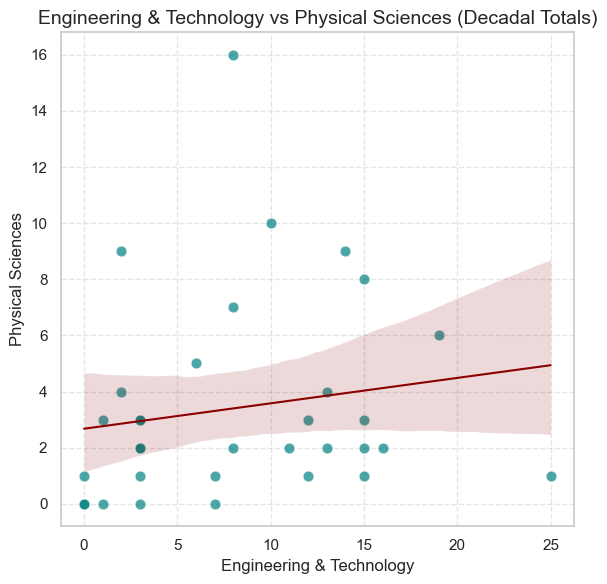

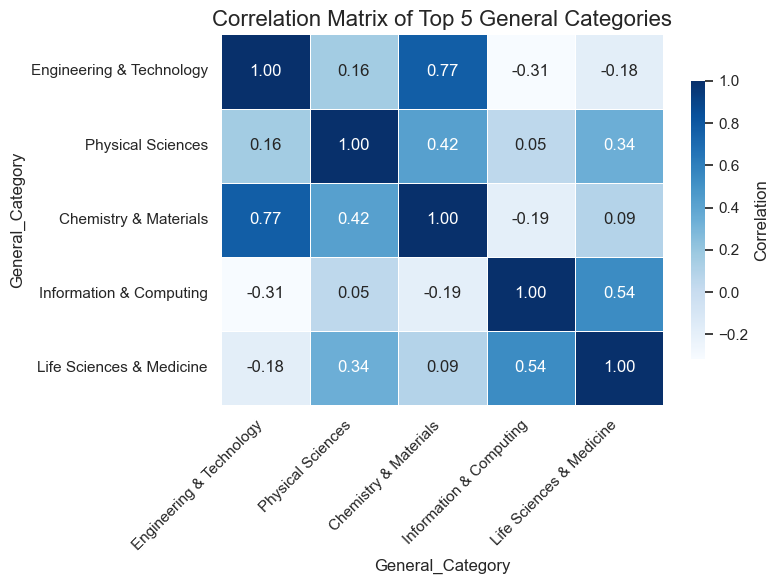

In [72]:
# Cell 12: Bivariate and correlation among top 5 general categories

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Reload and prepare the decade‐category pivot (reuse logic from Cell 11)
df = pd.read_csv('../../raw_data/clean_data/clean_data_dd.csv')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(int)
df['Decade'] = (df['Year'] // 10) * 10

decade_cat = (
    df.groupby(['Decade', 'General_Category'])
      .size()
      .reset_index(name='Count')
)
pivot_decade = decade_cat.pivot(
    index='Decade',
    columns='General_Category',
    values='Count'
).fillna(0)

# 2. Select the same top 5 categories as in Cell 11
top5 = pivot_decade.sum().sort_values(ascending=False).head(5).index
pivot_top5 = pivot_decade[top5]

# 3. Scatter plot for two representative categories
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=pivot_top5['Engineering & Technology'],
    y=pivot_top5['Physical Sciences'],
    s=60,
    color='teal',
    alpha=0.7
)
sns.regplot(
    x=pivot_top5['Engineering & Technology'],
    y=pivot_top5['Physical Sciences'],
    scatter=False,
    color='darkred',
    line_kws={'linewidth':1.5}
)
plt.title('Engineering & Technology vs Physical Sciences (Decadal Totals)', fontsize=14)
plt.xlabel('Engineering & Technology', fontsize=12)
plt.ylabel('Physical Sciences', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Correlation heatmap for the top 5 categories
corr_top5 = pivot_top5.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_top5,
    cmap='Blues',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'shrink':0.75, 'label':'Correlation'}
)
plt.title('Correlation Matrix of Top 5 General Categories', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The scatter plot of Engineering & Technology versus Physical Sciences decadal totals shows a weak positive trend. Each point is one ten-year bin, with its x-coordinate equal to the number of E&T inventions in that decade and its y-coordinate equal to the number of Physical Sciences inventions. Although there is considerable spread (some decades have many E&T inventions but few in Physical Sciences, and vice versa), the red regression line slopes upward, indicating that decades richer in engineering breakthroughs tend to have slightly more physical-science discoveries too.

The heatmap—our correlation matrix—quantifies these pairwise relationships across the five largest categories. Each cell holds the Pearson correlation coefficient between two categories’ decadal counts. Values range from –1.0 (perfect negative correlation) through 0 (no linear relationship) to +1.0 (perfect positive correlation). For example, Engineering & Technology and Chemistry & Materials have a high correlation of 0.77, meaning decades that see many engineering inventions almost always see many chemistry inventions as well. By contrast, Engineering & Technology and Information & Computing show a slight negative correlation (–0.31), reflecting that computing really took off later, when engineering growth had already peaked. In this way, the matrix highlights which fields rose and fell together over the centuries, and which followed largely independent trajectories.

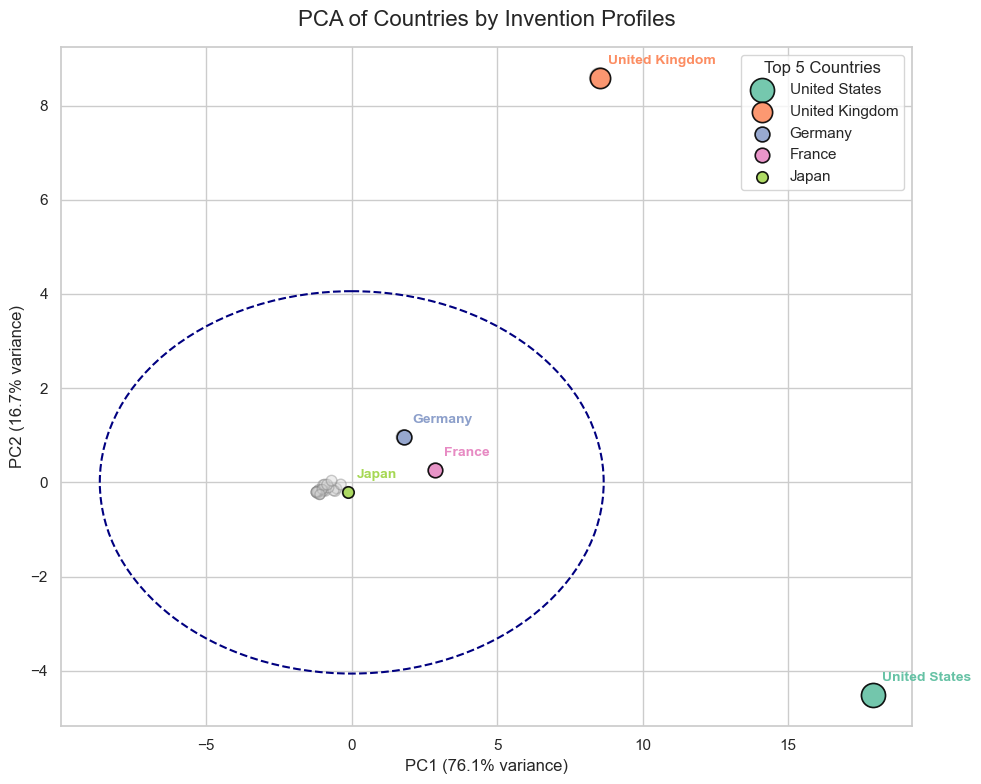

In [ ]:
# Cell 13: PCA scatter with custom colors, sizes, and confidence ellipse

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

# 1. Load & explode multi-country entries
df = pd.read_csv(
    '../../raw_data/clean_data/clean_data_dd.csv',
    usecols=['Country', 'General_Category']
)
country_split = (
    df['Country']
      .astype(str)
      .str.split(';')
      .explode()
      .str.strip()
)
df_expanded = df.loc[country_split.index].copy()
df_expanded['Country'] = country_split.values

# 2. Build country × category matrix
country_cat = (
    df_expanded
      .groupby(['Country', 'General_Category'])
      .size()
      .unstack(fill_value=0)
)

# 3. Standardize features for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(country_cat)

# 4. Compute PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
pc_df = pd.DataFrame(pcs, index=country_cat.index, columns=['PC1', 'PC2'])

# 5. Compute marker sizes by total inventions
totals = country_cat.sum(axis=1)
size_min, size_max = 50, 300
sizes = size_min + (totals - totals.min()) / (totals.max() - totals.min()) * (size_max - size_min)

# 6. Identify top 5 countries
top5 = ['United States', 'United Kingdom', 'Germany', 'France', 'Japan']
colors = sns.color_palette('Set2', len(top5))
top5_color_map = dict(zip(top5, colors))
default_color = 'lightgray'

# 7. Plot setup
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# 8. Plot all countries in gray
ax.scatter(
    pc_df['PC1'], pc_df['PC2'],
    s=sizes,
    c=default_color,
    edgecolor='gray',
    alpha=0.4,
    label='_nolegend_'
)

# 9. Plot top5 with colors and labels
for country in top5:
    if country in pc_df.index:
        x, y = pc_df.loc[country]
        ax.scatter(
            x, y,
            s=sizes.loc[country],
            color=top5_color_map[country],
            edgecolor='black',
            linewidth=1.2,
            alpha=0.9,
            label=country
        )
        ax.text(
            x + 0.3, y + 0.3,
            country,
            fontsize=10,
            fontweight='bold',
            color=top5_color_map[country]
        )

# 10. Draw 95% confidence ellipse
mean = pc_df.mean().values
cov = np.cov(pcs.T)
# chi-square quantile for 95% (2 dof)
chi2_val = chi2.ppf(0.95, df=2)
eigvals, eigvecs = np.linalg.eigh(cov)
order = eigvals.argsort()[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]
angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
width, height = 2 * np.sqrt(eigvals * chi2_val)
ellipse = Ellipse(
    xy=mean, width=width, height=height, angle=angle,
    edgecolor='navy', facecolor='none', linestyle='--', linewidth=1.5
)
ax.add_patch(ellipse)

# 11. Final formatting
var1, var2 = pca.explained_variance_ratio_[:2]
ax.set_xlabel(f'PC1 ({var1*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({var2*100:.1f}% variance)', fontsize=12)
ax.set_title('PCA of Countries by Invention Profiles', fontsize=16, pad=15)

ax.legend(title='Top 5 Countries', loc='upper right', frameon=True)
plt.tight_layout()
plt.show()


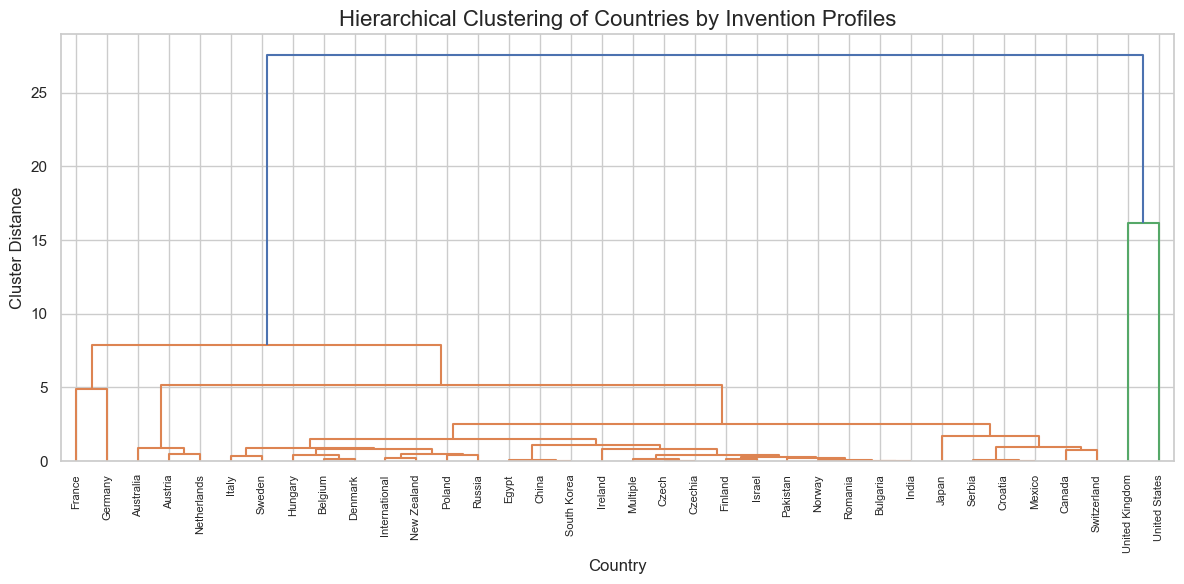

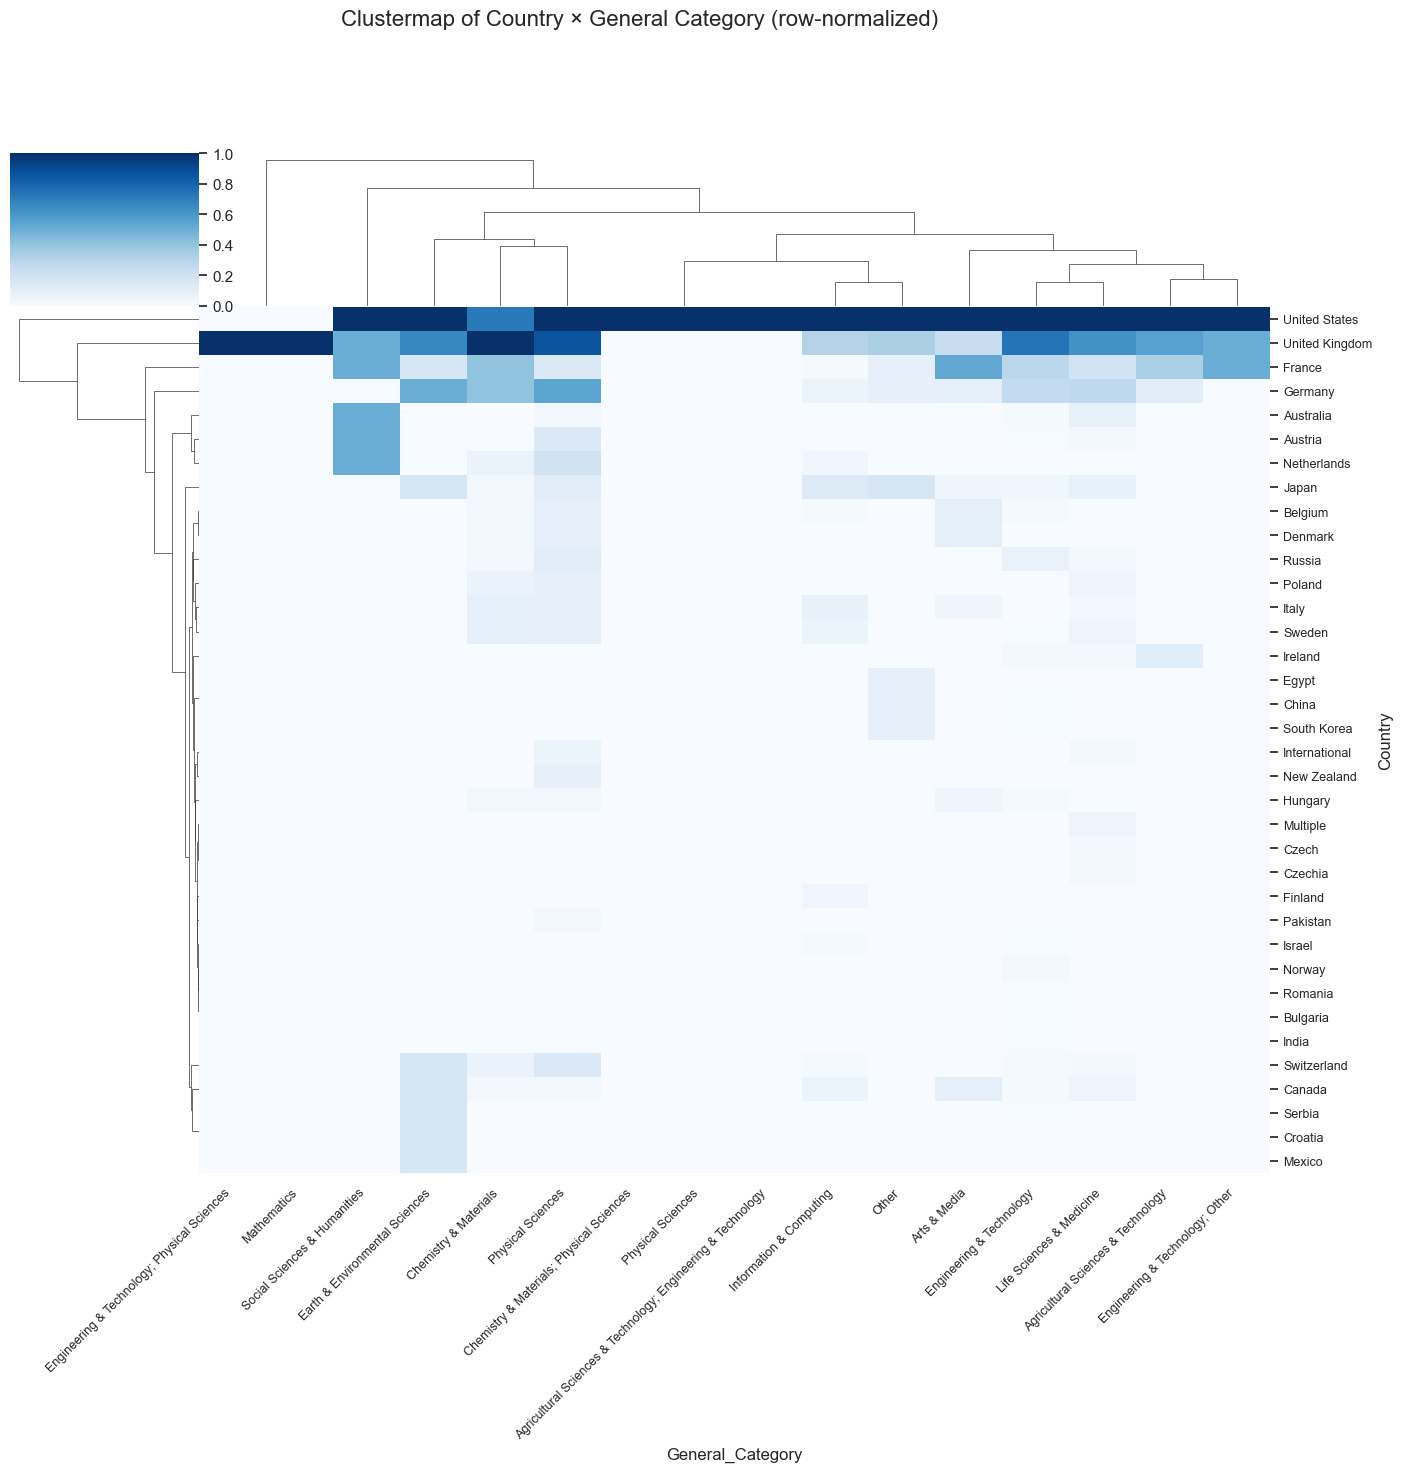

In [88]:
# Cell 14: Hierarchical clustering (dendrogram and clustermap)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# 1. Reuse country_cat and X_scaled from Cell 13

# 2. Compute linkage matrix with Ward’s method
link_mat = linkage(X_scaled, method='ward')

# 3. Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    link_mat,
    labels=country_cat.index,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=None
)
plt.title('Hierarchical Clustering of Countries by Invention Profiles', fontsize=16)
plt.xlabel('Country')
plt.ylabel('Cluster Distance')
plt.tight_layout()
plt.show()

cg = sns.clustermap(
    country_cat,
    cmap='Blues',
    standard_scale=1,
    row_cluster=True,
    col_cluster=True,
    figsize=(14, 12),           # overall size up
    dendrogram_ratio=(0.15, 0.15),  # more space for both trees
    cbar_pos=(0.02, 0.5, 0.03, 0.3),# (x, y, width, height) of colorbar
    xticklabels=True,
    yticklabels=True
)

# Rotate x labels for readability
plt.setp(cg.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)

# Move the row dendrogram a bit left
cg.ax_row_dendrogram.set_position([0.02, 0.1, 0.15, 0.8])
# Move the column dendrogram a bit up
cg.ax_col_dendrogram.set_position([0.17, 0.92, 0.6, 0.08])

# Title above everything
cg.fig.suptitle(
    'Clustermap of Country × General Category (row-normalized)', 
    y=1.02, 
    fontsize=16
)

# Tighten up layout
plt.subplots_adjust(
    left=0.05, right=0.95, 
    top=0.9, bottom=0.05
)
plt.show()


The PCA scatter in Cell 13 reveals that the United States sits far to the right on PC1—indicating it leads overwhelmingly in overall invention volume—while the United Kingdom scores highest on PC2, suggesting a relatively stronger balance across niche fields beyond pure engineering. Germany, France, and Japan occupy intermediate positions, showing they share similar multi-field profiles but do not dominate any single component to the same extreme.

In the next clustering, the dendrogram and clustermap split countries into clear groups: high-output leaders (U.S., U.K.) form their own cluster, mid-tier innovators (Germany, France, Japan, Switzerland) cluster together, and smaller-scale inventors (Nordic, Eastern European, and other nations) form lower-distance clusters. The heatmap confirms that top innovators have broad strengths across most categories, whereas smaller countries tend to concentrate or have very low activity in selective fields.